In [1]:
#neural network with adam and rmsprop with momentum
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#load the data
dataset = pd.read_csv('train.csv',dtype = np.float32)
print dataset.shape
dataset.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
data = dataset.iloc[:,1:].values
labels = dataset.iloc[:,0].values.reshape(-1,1)
print data.shape,labels.shape

(42000, 784) (42000, 1)


[ 3.]
[ 0.]
[ 0.]
[ 8.]
[ 9.]


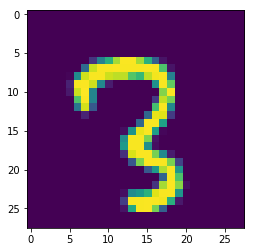

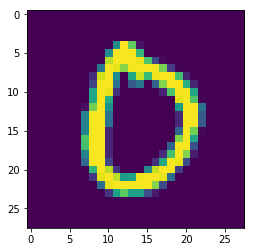

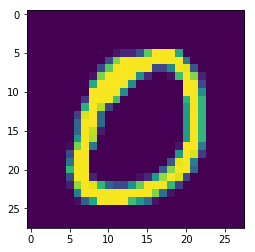

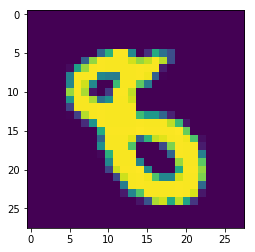

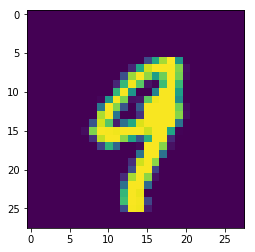

In [4]:
pixel_size = 28
#visualizing random samples from data
for i in np.random.randint(0,dataset.shape[0],5):
    temp = data[i,:].reshape(pixel_size,pixel_size)
    plt.figure()
    plt.imshow(temp)
    print labels[i,:]

In [5]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
scaler_x = StandardScaler()
data = scaler_x.fit_transform(data)

ohc  = OneHotEncoder()
labels = ohc.fit_transform(labels).toarray()
print data.shape,labels.shape

(42000, 784) (42000, 10)


In [6]:
#splitting the data in train and test sets
def split(data,labels,test_size = 0.1):
    n = labels.shape[0]
    perm = np.random.permutation(n)
    data = data[perm,:]
    labels = labels[perm,:]
    train_x,test_x = data[:-int(test_size*n),:],data[-int(test_size*n):,:]
    train_y,test_y = labels[:-int(test_size*n),:],labels[-int(test_size*n):,:]
    return train_x,test_x,train_y,test_y

train_x,test_x,train_y,test_y = split(data,labels)
print "Training : ",train_x.shape,train_y.shape
print "Testing : ",test_x.shape,test_y.shape

Training :  (37800, 784) (37800, 10)
Testing :  (4200, 784) (4200, 10)


In [7]:
def relu(x):
    return np.maximum(x,0)

def softmax(x):
    return np.exp(-x)/(np.sum(np.exp(-x),axis=1,keepdims=True))

def relu_grad(x):
    temp = np.zeros(x.shape)
    temp[x > 0] = 1
    return temp

def forward_prop(data,w1,b1,w2,b2):

    z1 = np.dot(data,w1) + b1
    a1 = relu(z1)
    #print 'a1',a1[:10,:10]
    z2 = np.dot(a1,w2) + b2
    a2 = softmax(z2)
    #print 'a2 : ',a2[:10,:]
    return a2,z2,a1,z1

def compute_loss(data,labels,weights,reg_param):
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    a2,z2,a1,z1 = forward_prop(data,w1,b1,w2,b2)
    l = -np.sum(np.sum(labels*np.log(a2)))/labels.shape[0]
    l += (reg_param/2.0)*(np.sum(np.sum(w1**2)) + np.sum(np.sum(w2**2)))/labels.shape[0]
    return l,[z1,a1,z2,a2]

def compute_gradients(x,y,logits,weights,reg_param):
    z1,a1,z2,a2 = logits[0],logits[1],logits[2],logits[3]
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    
    de = (y-a2)/y.shape[0]
    dw2 = np.dot(a1.T,de) + reg_param*w2/y.shape[0]
    db2 = np.sum(de,axis=0,keepdims=True)
    
    de = np.dot(de,w2.T)*relu_grad(z1)
    dw1 = np.dot(x.T,de) + reg_param*w1/y.shape[0]
    db1 = np.sum(de,axis=0,keepdims=True)
#     print 'w1',dw1[:10,:10]
#     print 'b1',db1[:,:10]
#     print 'w2',dw2[:10,:10]
#     print 'b2',db2[:,:10]
    return [dw1,db1,dw2,db2]

def update_weights(weights,grads,learning_rate):
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    dw1,db1,dw2,db2 = grads[0],grads[1],grads[2],grads[3]
    
    w1 -= learning_rate*dw1
    b1 -= learning_rate*db1
    w2 -= learning_rate*dw2
    b2 -= learning_rate*db2
    
    return w1,b1,w2,b2


def update_weights_rmsprop_with_momentum(weights,grads,learning_rate,caches
                                         ,velocity,e=1e-8,decay=0.99,mu = 0.9):
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    dw1,db1,dw2,db2 = grads[0],grads[1],grads[2],grads[3]
    vw1,vb1,vw2,vb2 = velocity[0],velocity[1],velocity[2],velocity[3]
    cw1,cb1,cw2,cb2 = caches[0],caches[1],caches[2],caches[3]
    
    vw1 = mu*vw1 + (1-mu)*learning_rate*dw1
    vb1 = mu*vb1 + (1-mu)*learning_rate*db1
    vw2 = mu*vw2 + (1-mu)*learning_rate*dw2
    vb2 = mu*vb2 + (1-mu)*learning_rate*db2
    
    cw1 = decay*cw1 + (1-decay)*(dw1**2)
    cb1 = decay*cb1 + (1-decay)*(db1**2)
    cw2 = decay*cw2 + (1-decay)*(dw2**2)
    cb2 = decay*cb2 + (1-decay)*(db2**2)
    
    w1 -= vw1/np.sqrt(cw1 + e)
    b1 -= vb1/np.sqrt(cb1 + e)
    w2 -= vw2/np.sqrt(cw2 + e)
    b2 -= vb2/np.sqrt(cb2 + e)
    
    weights = [w1,b1,w2,b2]
    velocity = [vw1,vb1,vw2,vb2]
    caches = [cw1,cb1,cw2,cb2]
    return weights,velocity,caches

def update_weights_adam(weights,grads,lr,caches,velocity,step,e=1e-8,beta1=0.9,beta2=0.99):
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    dw1,db1,dw2,db2 = grads[0],grads[1],grads[2],grads[3]
    vw1,vb1,vw2,vb2 = velocity[0],velocity[1],velocity[2],velocity[3]
    cw1,cb1,cw2,cb2 = caches[0],caches[1],caches[2],caches[3]
    
    vw1 = beta1*vw1 + (1-beta1)*dw1
    vb1 = beta1*vb1 + (1-beta1)*db1
    vw2 = beta1*vw2 + (1-beta1)*dw2
    vb2 = beta1*vb2 + (1-beta1)*db2
    
    cw1 = beta2*cw1 + (1-beta2)*(dw1**2)
    cb1 = beta2*cb1 + (1-beta2)*(db1**2)
    cw2 = beta2*cw2 + (1-beta2)*(dw2**2)
    cb2 = beta2*cb2 + (1-beta2)*(db2**2)
    
    #error correction
    correct1 = 1.0 - beta1**(step+1.0)
    #print correct1
    vw1_hat = vw1/correct1
    vb1_hat = vb1/correct1
    vw2_hat = vw2/correct1
    vb2_hat = vb2/correct1
    
    correct2 = 1.0 - beta2**(step+1.0)
    #print correct2
    cw1_hat = cw1/correct2
    cb1_hat = cb1/correct2
    cw2_hat = cw2/correct2
    cb2_hat = cb2/correct2
    
    w1 -= lr*vw1_hat/np.sqrt(cw1_hat + e)
    b1 -= lr*vb1_hat/np.sqrt(cb1_hat + e)
    w2 -= lr*vw2_hat/np.sqrt(cw2_hat + e)
    b2 -= lr*vb2_hat/np.sqrt(cb2_hat + e)
    
    weights = [w1,b1,w2,b2]
    velocity = [vw1,vb1,vw2,vb2]
    caches = [cw1,cb1,cw2,cb2]
    return weights,velocity,caches 

def compute_accuracy(data,labels,weights):
    w1,b1,w2,b2 = weights[0],weights[1],weights[2],weights[3]
    predictions,_,_,_ = forward_prop(data,w1,b1,w2,b2)
    val = np.sum(np.argmax(labels,axis=1) == np.argmax(predictions,axis=1))/labels.shape[0]
    return val

In [8]:
##default hyperparameters
def_lr = 0.001
def_n_iter = 1001
def_batch_size = 256
def_reg_param = 0.2

Training loss at step 0 is 2.55
Test accuracy at step 0 is 9.02%


Training loss at step 100 is 2.17
Test accuracy at step 100 is 34.07%


Training loss at step 200 is 1.70
Test accuracy at step 200 is 61.24%


Training loss at step 300 is 1.29
Test accuracy at step 300 is 74.12%


Training loss at step 400 is 1.02
Test accuracy at step 400 is 80.88%


Training loss at step 500 is 0.65
Test accuracy at step 500 is 85.29%


Training loss at step 600 is 0.52
Test accuracy at step 600 is 88.10%


Training loss at step 700 is 0.52
Test accuracy at step 700 is 89.76%


Training loss at step 800 is 0.37
Test accuracy at step 800 is 91.14%


Training loss at step 900 is 0.34
Test accuracy at step 900 is 92.36%


Training loss at step 1000 is 0.33
Test accuracy at step 1000 is 93.48%




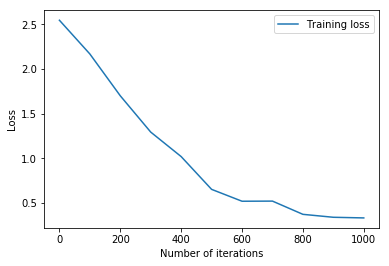

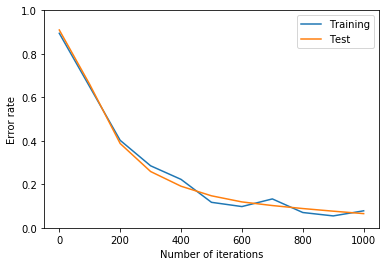

In [9]:
#hyperparamters
n,m = train_x.shape
learning_rate = def_lr
reg_param = def_reg_param
nh1 = 300
p = train_y.shape[1]
n_iter = def_n_iter
batch_size = def_batch_size
print_period = 100

#weights 
w1 = np.random.randn(m,nh1)/28
b1 = np.zeros((1,nh1))
w2 = np.random.randn(nh1,p)/np.sqrt(nh1)
b2 = np.zeros((1,p))
weights = [w1,b1,w2,b2]

#caches for rmsprop model
cw1 = 1
cb1 = 1
cw2 = 1
cb2 = 1
caches = [cw1,cb1,cw2,cb2]

#velocities of momentum model
vw1 = np.zeros(w1.shape)
vb1 = np.zeros(b1.shape)
vw2 = np.zeros(w2.shape)
vb2 = np.zeros(b2.shape)
velocity = [vw1,vb1,vw2,vb2]

#training the model
train_loss_1 = []
test_errs = []
train_errs = []

for step in range(n_iter):
    k = (step*batch_size) % (n - batch_size)
    batch_x = train_x[k:(k+batch_size)]
    batch_y = train_y[k:(k+batch_size)]
    
    l,logits = compute_loss(batch_x,batch_y,weights,reg_param)
    grads = compute_gradients(batch_x,batch_y,logits,weights,reg_param)
    weights,velocity,caches = update_weights_rmsprop_with_momentum(weights,grads,learning_rate,caches,velocity)

    
    
    if step%print_period ==0:
        train_loss_1.append(l)
        print "Training loss at step %d is %.2f" %(step,l)
        train_err =1.0 - compute_accuracy(batch_x,batch_y,weights)
        test_err =1.0 - compute_accuracy(test_x,test_y,weights)
        #print "Train accuracy at step %d is %.2f%%"  %(step,100.0*train_acc)
        print "Test accuracy at step %d is %.2f%%" %(step,100.0*(1.0-test_err))
        print '\n'
        train_errs.append(train_err)
        test_errs.append(test_err)
        #update the value of learning rate
        

plt.plot(np.arange(0,n_iter,100),train_loss_1,label = 'Training loss')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_iter,100),train_errs,label = 'Training')
plt.plot(np.arange(0,n_iter,100),test_errs,label = 'Test')
plt.ylim(0,1)
plt.xlabel('Number of iterations')
plt.ylabel('Error rate')
plt.legend()

Training loss at step 0 is 2.61
Test accuracy at step 0 is 8.52%


Training loss at step 100 is 2.33
Test accuracy at step 100 is 22.90%


Training loss at step 200 is 1.82
Test accuracy at step 200 is 51.98%


Training loss at step 300 is 1.35
Test accuracy at step 300 is 71.67%


Training loss at step 400 is 1.09
Test accuracy at step 400 is 79.79%


Training loss at step 500 is 0.68
Test accuracy at step 500 is 84.74%


Training loss at step 600 is 0.53
Test accuracy at step 600 is 87.76%


Training loss at step 700 is 0.54
Test accuracy at step 700 is 89.45%


Training loss at step 800 is 0.38
Test accuracy at step 800 is 90.83%


Training loss at step 900 is 0.32
Test accuracy at step 900 is 92.26%


Training loss at step 1000 is 0.33
Test accuracy at step 1000 is 93.17%




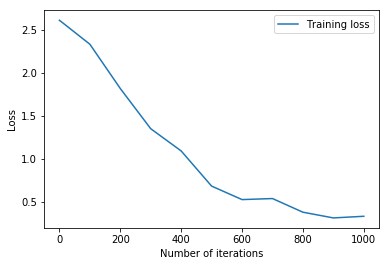

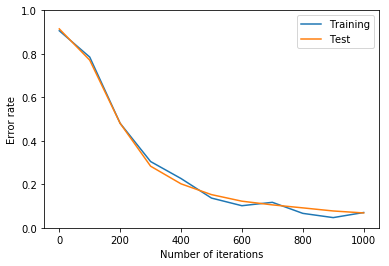

In [10]:
#Adam optimization

#hyperparamters
n,m = train_x.shape
learning_rate = def_lr
reg_param = def_reg_param
nh1 = 300
p = train_y.shape[1]
n_iter = def_n_iter
batch_size = def_batch_size
print_period = 100

#weights 
w1 = np.random.randn(m,nh1)/28
b1 = np.zeros((1,nh1))
w2 = np.random.randn(nh1,p)/np.sqrt(nh1)
b2 = np.zeros((1,p))
weights = [w1,b1,w2,b2]

#caches for rmsprop model
cw1 = 1
cb1 = 1
cw2 = 1
cb2 = 1
caches = [cw1,cb1,cw2,cb2]

#velocities of momentum model
vw1 = np.zeros(w1.shape)
vb1 = np.zeros(b1.shape)
vw2 = np.zeros(w2.shape)
vb2 = np.zeros(b2.shape)
velocity = [vw1,vb1,vw2,vb2]

#training the model
train_loss_adam = []
test_errs = []
train_errs = []

for step in range(n_iter):
    k = (step*batch_size) % (n - batch_size)
    batch_x = train_x[k:(k+batch_size)]
    batch_y = train_y[k:(k+batch_size)]
    
    l,logits = compute_loss(batch_x,batch_y,weights,reg_param)
    grads = compute_gradients(batch_x,batch_y,logits,weights,reg_param)
    weights,velocity,caches = update_weights_adam(weights,grads,learning_rate,caches,velocity,step)
    
    
    if step%print_period ==0:
        train_loss_adam.append(l)
        print "Training loss at step %d is %.2f" %(step,l)
        train_err =1.0 - compute_accuracy(batch_x,batch_y,weights)
        test_err =1.0 - compute_accuracy(test_x,test_y,weights)
        #print "Train accuracy at step %d is %.2f%%"  %(step,100.0*train_acc)
        print "Test accuracy at step %d is %.2f%%" %(step,100.0*(1.0-test_err))
        print '\n'
        train_errs.append(train_err)
        test_errs.append(test_err)
        #update the value of learning rate
        

plt.plot(np.arange(0,n_iter,100),train_loss_adam,label = 'Training loss')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(np.arange(0,n_iter,100),train_errs,label = 'Training')
plt.plot(np.arange(0,n_iter,100),test_errs,label = 'Test')
plt.ylim(0,1)
plt.xlabel('Number of iterations')
plt.ylabel('Error rate')
plt.legend()

Text(1,0.4,u'Learning rate : 0.0010')

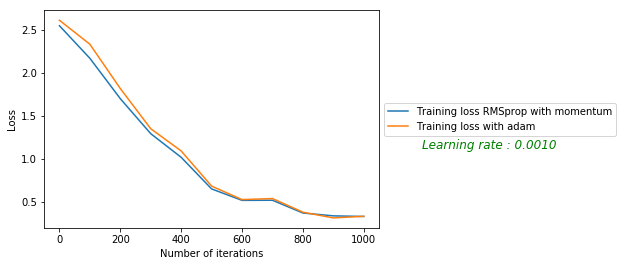

In [11]:
plt.figure()
plt.plot(np.arange(0,def_n_iter,print_period),train_loss_1,label='Training loss RMSprop with momentum')
plt.plot(np.arange(0,def_n_iter,print_period),train_loss_adam,label = 'Training loss with adam')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend(loc = 'center left',bbox_to_anchor = (1.0,0.5))
sr = 'Learning rate : {:.4f}'.format(def_lr)
plt.gcf().text(1.0,0.4,sr,style = 'italic',color = 'green',fontsize=12)